In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, Dropout
from keras.metrics import MeanSquaredError, RootMeanSquaredError
from sklearn.model_selection import train_test_split
from keras.utils.vis_utils import plot_model

In [2]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: METAL, pci bus id: <undefined>



2022-04-05 10:39:28.197259: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-05 10:39:28.197491: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
#doses pulled from Data Analysis/CLOCK_DATA/ACLK Graph - maybe automate this later
doses = np.array([0,5.44,10.88,16.32,21.76,27.2,32.64,38.08,48.96,54.4,59.84,0,5.44,10.88,16.32,21.76,27.2,32.64,38.08,48.96,54.4,59.84,0,5.44,10.88,16.32,21.76,27.2,32.64,38.08,48.96,54.4,59.84])
doses_mean = doses.mean()
doses_std = doses.std()
doses = (doses - doses_mean) / doses_std #normalize
#to get original do reverse of normalization o = (x * doses_std) + doses_mean

In [4]:
def rolling_window(a, window):
    pad = np.ones(len(a.shape), dtype=np.int32)
    pad[-1] = window-1
    pad = list(zip(pad, np.zeros(len(a.shape), dtype=np.int32)))
    a = np.pad(a, pad,mode='reflect')
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

In [5]:
#load data
trial_path = "/Users/trevorpeyton/Downloads/"
trial_numbers = [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11]
channels = ["Channel1"]
modes = ["LPM0", "LPM2", "LPM4-2"]
trial_labels = [[f"{channel}/{mode}_Trial{number}" for number in trial_numbers for channel in channels] for mode in modes] #["Channel1/LPM0_Trial0", "Channel1/LPM0_Trial91"]
trials = [[pd.read_csv(trial_path + label + ".csv", usecols=[3, 4], names=["time", "v"]).v.to_numpy()[::] for label in mode_labels] for mode_labels in trial_labels]

trial_slde_width = 1000
test_percent = .2
val_percent = .2 #percent of test set to be reserved for validation

#format data
train_label_values = list(doses)
data, data_y, train, train_y, test, test_y, val, val_y = ( [[] for _ in range(len(modes))] for _ in range(8) ) #setup with len(modes) empty arrays for each modes data
for i, mode_trials in enumerate(trials):
    for n, trial in enumerate(mode_trials):
        #normalize all values using z-score
        trial_copy = np.zeros(trial.shape)
        trial_copy[trial > 2] = (trial[trial > 2] - trial[trial > 2].mean()) / trial[trial > 2].std()
        trial_copy[trial < 2] = (trial[trial < 2] - trial[trial < 2].mean()) / trial[trial < 2].std()
        for win in np.lib.stride_tricks.sliding_window_view(trial_copy, trial_slde_width)[::100]: #slide window across
            # data[i].append(np.stack([win,
            #                          np.mean(rolling_window(win, 4), axis=-1),
            #                          np.std(rolling_window(win, 4), axis=-1),
            #                          np.gradient(win, 4)], axis=1)) #-- With gradient
            data[i].append(win) #-- Without gradient
            data_y[i].append(train_label_values[n])

#split train/test/val
for mode in range(len(modes)):
    temp_train, temp_test, temp_train_y, temp_test_y = train_test_split(data[mode], data_y[mode], test_size = test_percent, random_state=2)
    temp_test, temp_val, temp_test_y, temp_val_y = train_test_split(temp_test, temp_test_y, test_size = val_percent, random_state=2)
    train[mode] = np.asarray(temp_train)
    train_y[mode] = np.asarray(temp_train_y)
    test[mode] = np.asarray(temp_test)
    test_y[mode] = np.asarray(temp_test_y)
    val[mode] = np.asarray(temp_val)
    val_y[mode] = np.asarray(temp_val_y)

#trials = data = data_y = None #clear up some memory

In [6]:
#model creation
models = []
model = Sequential()

model.add(Conv1D(8, train[0].shape[1], activation="relu", padding="same", input_shape=(train[0].shape[1], 1),
                 kernel_regularizer=keras.regularizers.l2(l=0.1),
                 bias_regularizer=keras.regularizers.l2(0.01)
                ))
model.add(MaxPooling1D(8))

model.add(Conv1D(6, train[0].shape[1], activation="relu", padding='same',
                 kernel_regularizer=keras.regularizers.l2(l=0.1),
                 bias_regularizer=keras.regularizers.l2(0.01)
                ))
model.add(MaxPooling1D(6))

model.add(Conv1D(4, train[0].shape[1], activation="relu", padding='same',
                 kernel_regularizer=keras.regularizers.l2(l=0.1),
                 bias_regularizer=keras.regularizers.l2(0.01)
                ))
model.add(MaxPooling1D(4))

model.add(Flatten())
model.add(Dropout(.4))
model.add(Dense(1))

for mode in range(len(modes)):
    m = keras.models.clone_model(model)
    m.compile(loss = 'mse',
              optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5),
              metrics = [MeanSquaredError(), RootMeanSquaredError()]) #each model has to be compiled seperatly
    models.append(m)

2022-04-05 10:39:30.045229: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-05 10:39:30.045253: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
#plot_model(models[0], to_file='model.png')

In [8]:
#train each model seperatly
#red_lr=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_mean_squared_error", factor=0.1, patience=5, verbose=0, mode="auto", min_lr=0.001)
histories = {}
for n, model in enumerate(models):
    print(f"\n\nTraining model {n} - ({modes[n]}) \n")
    
    histories[modes[n]] = model.fit(train[n][..., None], train_y[n], batch_size=2048, epochs=40, verbose=0, validation_data=(val[n][..., None], val_y[n]))#, callbacks=[red_lr])



Training model 0 - (LPM0) 



2022-04-05 10:39:39.165065: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-05 10:39:39.510157: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-05 10:39:42.234900: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.




Training model 1 - (LPM2) 



2022-04-05 10:41:17.519056: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-05 10:41:20.138082: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.




Training model 2 - (LPM4-2) 



2022-04-05 10:42:55.544922: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-05 10:42:58.149246: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


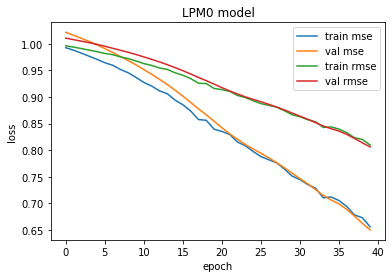

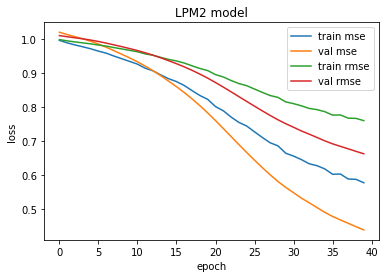

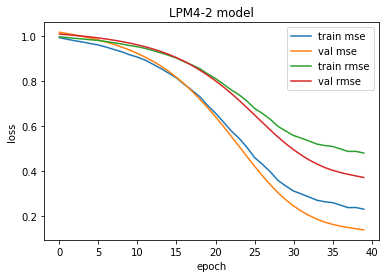

In [11]:
for mode in histories:
        history = histories[mode]
        _=plt.figure(facecolor='white')
        plt.plot(history.history['mean_squared_error'])
        plt.plot(history.history['val_mean_squared_error'])
        plt.plot(history.history['root_mean_squared_error'])
        plt.plot(history.history['val_root_mean_squared_error'])
        plt.title(f"{mode} model")
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train mse', 'val mse', 'train rmse', 'val rmse'], loc='upper right')
        plt.show()

In [14]:
print(models[0].metrics_names)
for mode in range(len(modes)):
    print(f"{modes[mode]} {models[mode].evaluate(test[mode][..., None], test_y[mode], verbose=0)}")

['loss', 'mean_squared_error', 'root_mean_squared_error']
LPM0 [1.5361948013305664, 0.6284447908401489, 0.7927451133728027]
LPM2 [1.4458519220352173, 0.5273755192756653, 0.7262062430381775]
LPM4-2 [1.0733568668365479, 0.14165790379047394, 0.3763746917247772]


In [ ]:
for n, model in enumerate(models):
    model.save(f"models/model_{modes[n]}.h5")

In [40]:
#show some predictions from test dataset
start = 40
predictions = 10
for mode in range(len(modes)):
    print(f"\nPredicting {predictions} values - ({modes[mode]}) \n")
    for n in range(start, start+predictions):
        print(f"\tPredicted: {(models[mode](test[mode][n][None, ..., None]).numpy() * doses_std) + doses_mean}, expected: {(test_y[mode][n] * doses_std) + doses_mean}")


Predicting 10 values - (LPM0) 

	Predicted: [[43.189327]], expected: 48.96
	Predicted: [[2.7441368]], expected: 0.0
	Predicted: [[29.752048]], expected: 27.2
	Predicted: [[37.892002]], expected: 59.84
	Predicted: [[27.591314]], expected: 10.880000000000003
	Predicted: [[27.064032]], expected: 27.2
	Predicted: [[27.181467]], expected: 16.32
	Predicted: [[7.4202003]], expected: 5.440000000000001
	Predicted: [[25.59179]], expected: 16.32
	Predicted: [[29.281408]], expected: 59.84

Predicting 10 values - (LPM2) 

	Predicted: [[39.32482]], expected: 48.96
	Predicted: [[12.349432]], expected: 0.0
	Predicted: [[40.03598]], expected: 27.2
	Predicted: [[56.070457]], expected: 59.84
	Predicted: [[12.958687]], expected: 10.880000000000003
	Predicted: [[35.401516]], expected: 27.2
	Predicted: [[12.916409]], expected: 16.32
	Predicted: [[14.470435]], expected: 5.440000000000001
	Predicted: [[16.2341]], expected: 16.32
	Predicted: [[55.37911]], expected: 59.84

Predicting 10 values - (LPM4-2) 

	Pr